In [1]:
!pip install -q xlrd
!git clone https://github.com/Lossophy/BINA-Projekt.git

Cloning into 'BINA-Projekt'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 140 (delta 71), reused 34 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (140/140), 3.58 MiB | 7.08 MiB/s, done.
Resolving deltas: 100% (71/71), done.


Vorbereitung der benötigten Bibliotheken

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import time
from IPython.display import display, clear_output

Import & Überprüfung der der Daten

In [3]:
# Datei einlesen
df = pd.read_csv('/content/BINA-Projekt/Data/ogd115_gest_bilanz.csv')

# Daten überprüfen
print(df.head())


   Jahr           Rubrik Energietraeger        TJ
0  1980  Bruttoverbrauch   Elektrizität  -29450.0
1  1980  Bruttoverbrauch  Erdölprodukte  321250.0
2  1980  Bruttoverbrauch      Fernwärme       0.0
3  1980  Bruttoverbrauch            Gas   36280.0
4  1980  Bruttoverbrauch    Holzenergie   26280.0


**Beschreibung der Daten:**
Die Daten wurden von der  SFOE (Swiss Federal Office of Energy) heruntergeladen. Unter folgendem Link https://opendata.swiss/en/dataset/energiebilanz-der-schweiz/resource/1957ce24-bc06-40f8-a630-6db5bee3c419.


---
Der Datensatz hat die Spalten "Jahr", "Rubrik", "Energieträger" und "TJ".

Die Daten sind vom Jahr 1980 bis und mit 2023.

Es werden die folgenden Rubriken unterschieden:


*   Bruttoverbrauch =
*   Eigenverbrauch des Energiesektors, Netzverluste, Verbrauch der Speicherungen =
*   Endverbrauch - Dienstleistungen =
*   Endverbrauch - Haushalte =
*   Endverbrauch - Industrie =
*   Endverbrauch - Statistische Differenz inkl. Landwirtschaft =
*   Endverbrauch - Total =
*   Endverbrauch - Verkehr =
*   Energieumwandlung - Diverse Erneuerbare =
*   Energieumwandlung - Gaswerke =
*   Energieumwandlung - Kernkraftwerke =
*   Energieumwandlung - Raffinerien =
*   Energieumwandlung - Wasserkraftwerke
*   Energieumwandlung - konventionell-thermische Kraft-, Fernheiz- und Fernheizkraftwerke =
*   Export =
*   Import =
*   Inlandproduktion =
*   Lagerveränderung =
*   Nichtenergetischer Verbrauch =




1 Terajoule entspricht dabei 277'777,777 KWh. Zur besseren Einordnung kann die grösse der Energieeinheit mit folgendem Durchschnittswert dargestellt werden. Ein durchschnitts Haushalt mit 4 Personen in der Schweiz braucht ca. 4'500 KWh pro Jahr (https://www.energieheld.ch/renovation/nachhaltig-leben/energieverbrauch).

Als erstes möchten wir sehen, wie sich der allgemeine Verbrauch je Energieträger verändert hat.

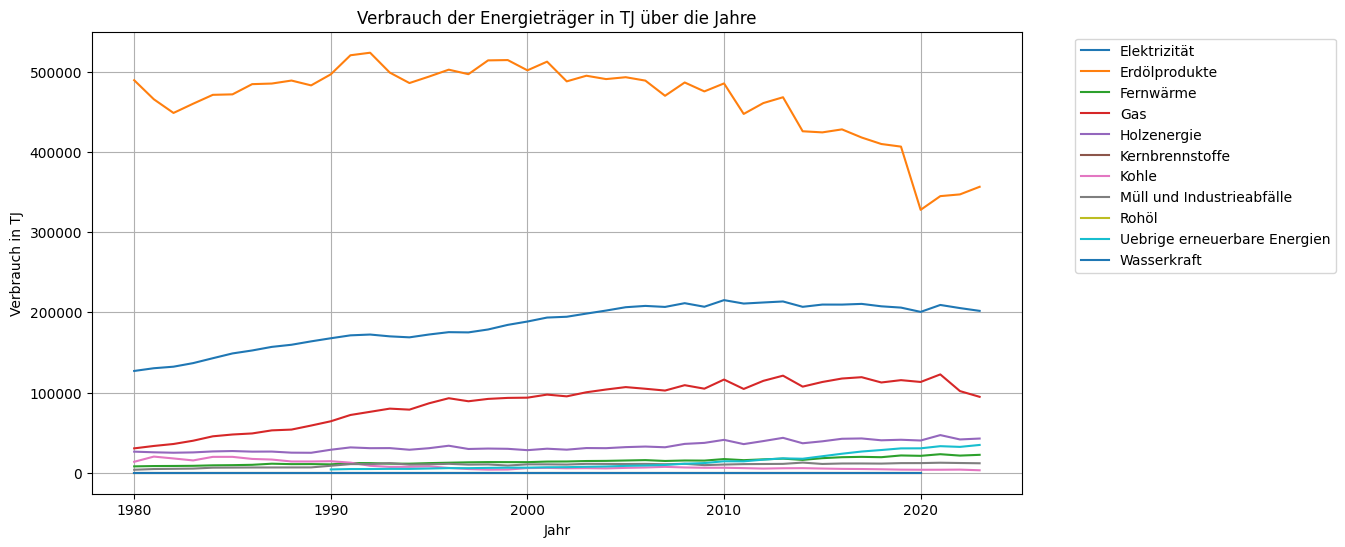

In [4]:
df_filtered = df[
    (df['Energietraeger'].isin([
        'Elektrizität', 'Erdölprodukte', 'Fernwärme', 'Gas', 'Holzenergie',
        'Kernbrennstoffe', 'Kohle', 'Müll und Industrieabfälle',
        'Rohöl', 'Uebrige erneuerbare Energien', 'Wasserkraft'
    ])) &
    (df['Rubrik'] == 'Endverbrauch - Total')
]
df_pivot = df_filtered.pivot(index='Jahr', columns='Energietraeger', values='TJ')


# Plot erstellen
plt.figure(figsize=(12, 6))
for column in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[column], label=column)

plt.xlabel('Jahr')
plt.ylabel('Verbrauch in TJ')
plt.title('Verbrauch der Energieträger in TJ über die Jahre')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


Um die Bedeutung zu bestimmen kann man die effektiven Zahlen anschauen oder auch die Enwicklung gegenüber dem vergangenen Jahr.

<ipython-input-5-fb24cb1a0139>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_pct_change = df_pivot.pct_change() * 100


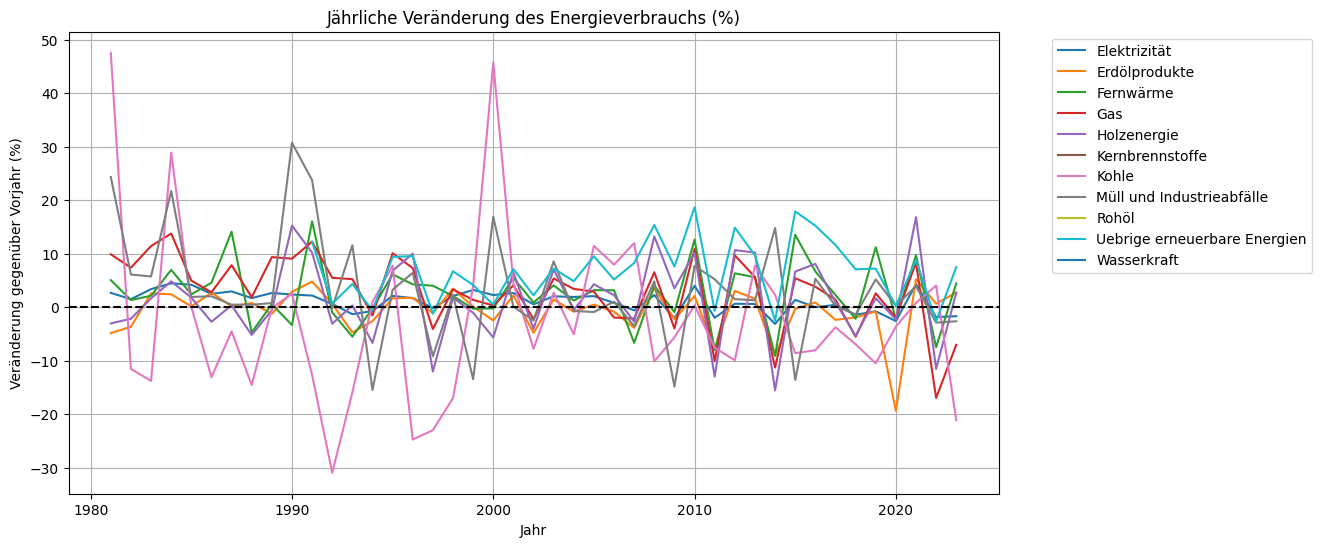

In [5]:
# Veränderung vom Verbrauch über die Jahre
df_pct_change = df_pivot.pct_change() * 100


plt.figure(figsize=(12, 6))
for column in df_pct_change.columns:
    plt.plot(df_pct_change.index[1:], df_pct_change[column][1:], label=column) #Start vom zweiten Jahr

plt.xlabel('Jahr')
plt.ylabel('Veränderung gegenüber Vorjahr (%)')
plt.title('Jährliche Veränderung des Energieverbrauchs (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()


In [6]:
# 1. Filterung (kombiniert)
df_filtered = df[
    (df['Energietraeger'].isin([
        'Elektrizität', 'Erdölprodukte', 'Fernwärme', 'Gas', 'Holzenergie',
        'Kernbrennstoffe', 'Kohle', 'Müll und Industrieabfälle',
        'Rohöl', 'Uebrige erneuerbare Energien', 'Wasserkraft'
    ])) &
    (df['Rubrik'] == 'Endverbrauch - Total')
]

# 2. Gruppieren und Pivot-Tabelle erstellen
df_grouped = df_filtered.groupby(['Jahr', 'Energietraeger'])['TJ'].sum().reset_index()
df_pivot = df_grouped.pivot(index='Jahr', columns='Energietraeger', values='TJ')

# 3. Fehlende Werte vorwärts auffüllen (z. B. bei einzelnen Energieträgern in bestimmten Jahren)
df_pivot = df_pivot.sort_index().ffill()

# 4. Prozentuale Veränderung berechnen
df_pct_change = df_pivot.pct_change() * 100
df_pct_change = df_pct_change.reset_index()  # Jahr wird zur Spalte

# 5. In Long-Format umwandeln für Plotly
df_long = df_pct_change.melt(id_vars='Jahr', var_name='Kategorie', value_name='Veränderung [%]')

# 6. Interaktiver Plotly-Plot
fig = px.line(
    df_long,
    x='Jahr',
    y='Veränderung [%]',
    color='Kategorie',
    title='Jährliche Veränderung des Energieverbrauchs (%)',
    markers=True
)

fig.add_hline(y=0, line_dash='dash', line_color='black')

fig.update_layout(
    xaxis_title='Jahr',
    yaxis_title='Veränderung gegenüber Vorjahr (%)',
    legend_title='Energieträger',
    hovermode='x unified'
)

fig.show()


Um einen besseren Überblick über die genauere Verteilung der Energieträger zu erhalten, wollen wir nun Pie-Charts pro Jahr anschauen.

In [7]:
def plot_daten(jahr):
    gefiltert = df[(df['Jahr'] == jahr) & (df['Rubrik'] == 'Endverbrauch - Total')]

    if gefiltert.empty:
        print("Keine Daten für diese Kombination.")
        return

    energie_verbrauch = gefiltert.groupby('Energietraeger')['TJ'].sum()
    percentages = energie_verbrauch / energie_verbrauch.sum() * 100
    filtered_energie_verbrauch = energie_verbrauch[percentages >= 0.1]  # Es werden nur Daten mit bestimmter %-Angabe angezeigt

    # Spezifische Legende erstellt
    legend_labels = [f'{label}: {percentages[label]:.1f}%' for label in filtered_energie_verbrauch.index]

    plt.figure(figsize=(10, 6))
    wedges, texts, autotexts = plt.pie(filtered_energie_verbrauch, autopct='', startangle=90) # autopct ist leer und kann später ergänzt werden
    plt.title(f"Verbrauch der Energieträger im Jahr {jahr}")
    plt.axis('equal')
    plt.legend(wedges, legend_labels, title="Energieträger", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))


    plt.show()

#Interaktive Ansicht verbinden
jahr_widget = widgets.IntSlider(min=df['Jahr'].min(), max=df['Jahr'].max(), step=1, description='Jahr:')
ui = widgets.VBox([jahr_widget])
out = widgets.interactive_output(plot_daten, {'jahr': jahr_widget,})

display(ui, out)

Output()

In [16]:
# Darstellung anhand Kategorie Industrie, Haushalte etc.

# 1. Filterung (kombiniert)
df_filtered = df[
    (df['Energietraeger'].isin([
        'Elektrizität', 'Erdölprodukte', 'Fernwärme', 'Gas', 'Holzenergie',
        'Kernbrennstoffe', 'Kohle', 'Müll und Industrieabfälle',
        'Rohöl', 'Uebrige erneuerbare Energien', 'Wasserkraft'
    ])) &
    (df['Rubrik'].isin([
        'Endverbrauch - Dienstleistungen',
        'Endverbrauch - Haushalte', 'Endverbrauch - Industrie',
        'Endverbrauch - Statistische Differenz inkl. Landwirtschaft',
        'Endverbrauch - Verkehr']))
]

# Gruppieren und Pivot-Tabelle erstellen
df_grouped = df_filtered.groupby(['Jahr', 'Rubrik'])['TJ'].sum().reset_index()
df_pivot = df_grouped.pivot(index='Jahr', columns='Rubrik', values='TJ')
df_long = df_grouped.rename(columns={'Rubrik': 'Kategorie', 'TJ': 'Verbrauch [TJ]'})

# Interaktiver Plotly-Plot
fig = px.line(
    df_long,
    x='Jahr',
    y='Verbrauch [TJ]',
    color='Kategorie',
    title='Jährlicher Verbrauch',
    markers=True
)

fig.add_hline(y=0, line_dash='dash', line_color='black')

fig.update_layout(
    xaxis_title='Jahr',
    yaxis_title='Jährlicher Verbrauch',
    legend_title='Kategorie',
    hovermode='x unified'
)

fig.show()